In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
import re
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from collections import Counter
from sklearn import linear_model
import csv
from datetime import datetime
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
df1=pd.read_csv("../data/train_1.csv")

In [5]:
matrix = df1.iloc[:, 1:].values 
z = np.where(np.isnan(matrix))
#matrix_remove_2_29 = np.delete(matrix, 120, axis=1) # 2017 does not have Feb 29th
print(matrix.shape) #(145063, 550)

(145063, 550)


In [6]:
page_num = matrix.shape[0]
days = matrix.shape[1]

In [7]:
delete_nan_row = {}
print(z[0])
for x in z[0]:
    if x in delete_nan_row:
        delete_nan_row[x] += 1
    else:
        delete_nan_row[x] = 1


[     4      4      4 ..., 145062 145062 145062]


In [8]:
hp_threshold_up = 100
hp_threshold_low = 50# delete row if its NaN larger than this
#idx_interpt = [k for k, v in delete_nan_row.iteritems() if v < hp_threshold_up and v > hp_threshold_low]
idx_interpt = [k for k, v in delete_nan_row.iteritems() if v < days]
idx_all_nan = [k for k, v in delete_nan_row.iteritems() if v == days]
print(len(idx_interpt))
print(len(idx_all_nan))

27134
652


In [52]:
print(idx_interpt)

[4, 6, 10, 13, 131088, 19, 24, 27, 37, 38, 48, 131123, 52, 53, 54, 55, 56, 60, 64, 66, 68, 70, 73, 78, 80, 81, 82, 83, 89, 91, 94, 95, 97, 99, 101, 103, 104, 106, 109, 111, 112, 113, 114, 131190, 119, 129, 135, 136, 131216, 146, 147, 149, 151, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 165, 171, 172, 175, 176, 131257, 131289, 251, 282, 131392, 131126, 371, 417, 131509, 131540, 470, 131549, 131571, 568, 570, 131654, 617, 131722, 131724, 131726, 131728, 684, 131765, 719, 131794, 131795, 724, 131797, 131798, 131799, 131800, 729, 131802, 131803, 131804, 131805, 131806, 131807, 131808, 131809, 131810, 131811, 131812, 131813, 131814, 131815, 131816, 131817, 131818, 131819, 131820, 131821, 131822, 131823, 131824, 131825, 131826, 131827, 131828, 131829, 131830, 131831, 131832, 131833, 131834, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846, 131847, 131848, 131849, 131850, 131851, 131852, 131853, 131854, 131855, 131856, 131857, 786, 131859, 

In [11]:
a1 = np.array([np.nan, 7, 8, 0,np.nan])
a2 = np.array([np.nan, np.nan, np.nan, 7, 8, 0,np.nan])
a3 = np.array([8, 9, np.nan, 7, 8, 0,np.nan])

def start_idx(w):
    nan_idx = np.where(np.isnan(w))[0]
    cnt = 0
    while cnt < len(nan_idx) and nan_idx[cnt] == cnt:
        cnt += 1
    return cnt

print(start_idx(a1))
print(start_idx(a2))
print(start_idx(a3))

a3[0:0] = 0
print(a3)

1
3
0
[  8.   9.  nan   7.   8.   0.  nan]


In [13]:
new_matrix = np.copy(matrix)
start_dict = {}
x = np.arange(0, days)
for i in range(len(idx_interpt)):
    i_real = idx_interpt[i]
    w = matrix[i_real, :]
    start = start_idx(w)
    start_dict[i_real] = start 
    w[0:start] = 0
    yy_idx = np.where(np.isnan(w))[0]
    yy = np.delete(w, yy_idx)
    xx = np.delete(x, yy_idx)
    f = interp1d(xx, yy, kind = 'nearest', fill_value = "extrapolate")
    ynew = f(x)
    new_matrix[i_real, :] = ynew
print(new_matrix.shape)    

(145063, 550)


In [76]:
matrix_linear = np.copy(matrix)
start_dict = {}
x = np.arange(0, days)
for i in range(len(idx_interpt)):
    i_real = idx_interpt[i]
    w = matrix[i_real, :]
    start = start_idx(w)
    start_dict[i_real] = start 
    w[0:start] = 0
    yy_idx = np.where(np.isnan(w))[0]
    yy = np.delete(w, yy_idx)
    xx = np.delete(x, yy_idx)
    if (xx[-1] != days - 1):
        xx = np.append(xx, days - 1)
        yy = np.append(yy, 0)
    f = interp1d(xx, yy, kind = 'slinear')
    ynew = f(x)
    matrix_linear[i_real, :] = ynew
print(matrix_linear.shape)    

(145063, 550)


In [77]:
matrix_linear[idx_all_nan, :] = 0

In [14]:
new_matrix[idx_all_nan, :] = 0

In [78]:

num_ttw = 56
stat = 'median'

sub_data_pre = matrix_linear[:, -num_ttw:]

result = np.zeros((page_num, 60))
#y = np.median(sub_data_pre[:, -num_ttw:], axis = 1)
for i in range(60):
    y = np.median(sub_data_pre[:, -num_ttw:], axis = 1)
    result[:, i] = y
    y = np.reshape(y, (len(y), 1))
    sub_data_pre = np.append(sub_data_pre, y, axis = 1)
print('completing')
print('shape of result', result.shape)
generate_submission_2(result)



completing
('shape of result', (145063, 60))


In [19]:
ww = csv.writer(open("../result/first_non_NaN_start_dict.csv", "w"))
for key, val in start_dict.items():
    ww.writerow([key, val])

In [48]:
round_matrix = np.rint(new_matrix)
int_matrix = round_matrix.astype(np.int32)

np.savetxt("../result/clean_NaN_nearest_int.csv", int_matrix, fmt='%i', delimiter=",")

In [51]:
np.savetxt("../result/clean_NaN_linear_int.csv", matrix_linear, fmt='%i', delimiter=",")

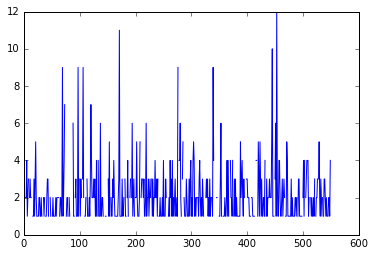

(array([  1,   2,   9,  14,  15,  24,  33,  34,  38,  45,  46,  49,  50,
        63,  74,  75,  80,  83,  85,  86,  87,  91,  99, 104, 108, 112,
       115, 132, 143, 145, 148, 150, 155, 164, 167, 180, 184, 188, 189,
       192, 199, 205, 209, 212, 228, 241, 256, 257, 258, 277, 283, 286,
       323, 325, 341, 343, 344, 347, 349, 355, 356, 368, 369, 375, 385,
       396, 398, 407, 414, 415, 418, 433, 438, 449, 468, 475, 483, 490,
       499, 504, 512, 513, 522, 527, 536]),)


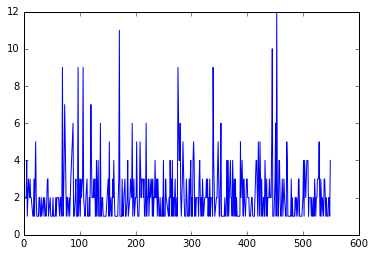

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ 2.          2.          2.5         1.66666667  1.33333333  1.
  1.33333333  1.66666667  1.5         1.33333333  1.66666667  1.          1.
  1.5         5.          3.          1.5         2.          3.75        4.5
  5.25        1.5         2.          2.5         1.5         2.5         1.
  2.5         1.          1.          1.5         2.5         1.5         1.
  1.          2.5         1.5         1.33333333  1.66666667  2.5         1.5
  1.          3.5         3.          2.5         2.          1.75        1.5
  1.25        6.5         2.          

In [67]:
y = matrix[idx_interpt[2000], :]
x = np.arange(0, len(y))
plt.plot(x, y)
plt.show()

yy_idx = np.where(np.isnan(y))
print(yy_idx)
yy = np.delete(y, yy_idx)
xx = np.delete(x, yy_idx)
f = interp1d(xx, yy)
xnew = np.arange(0, len(y))
ynew = f(xnew) # use interpolation function returned by `interp1d`
plt.plot(xnew, ynew)
plt.show()

print(y[yy_idx])
print(ynew[yy_idx])

In [68]:
from datetime import datetime

def strc(x):
    s = str(x) if x >= 10 else '0' + str(x)
    return s

def generate_submission_2(result):
    ttime = datetime.now()
    time2str = strc(ttime.month) + strc(ttime.day) + strc(ttime.hour) + strc(ttime.minute)
    filename = '../result/submission_' + time2str + '.csv'
    days = 60
    page_num = 145063
    if isinstance(result, pd.DataFrame):
        temp = result.values
    elif isinstance(result, np.ndarray):
        temp = result
    else:
        print('to do')
    submission_result = pd.read_csv('../data/sample_submission_1.csv')
    sub_res = submission_result.values
    map_pos = pd.read_csv('../tmp/map_pos.csv').values


    if temp.shape != (page_num, days):
        print('to do')
        return

    with open(filename, 'wb') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Id', 'Visits'])
        for i in range(page_num * days):
            value = result[map_pos[i, 0], map_pos[i, 1]]
            writer.writerow([sub_res[i, 0], value])

In [66]:
submission_result = pd.read_csv('../data/sample_submission_1.csv')
sub_res = submission_result.values
print(sub_res.shape)

(1048575, 2)
